In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL
import matplotlib.pyplot as plt

In [2]:
def adf_test(timeseries, maxlag=None, regression='c', autolag='AIC'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)



# Задание 4. Влияние шоков нефтяных цен на экономику США

Файл с данными: `USMacro_Monthly`. 

Повышение цен на нефть не раз становилось причиной рецессий в развитых странах. Для эмпирического исследования последствий шоков цен на нефть воспользуемся следующими данными:

$\mathrm{Oil_t}$ = max(0, разность между ценой нефти в момент времени $\small t$ и ее максимальным значением в предшествующий моменту $\small t$ год). 
<small>(Переменная измеряется в процентных пунктах).</small> 
Таким образом, переменная равна нулю, если шок цен на нефть в текущем периоде отсутствует (текущая цена нефти не превышает максимум за прошедший год).

$\mathrm{IP_t}$ — индекс промышленного производства в США в месяце $\small t$. 

Будем предполагать, что цены на нефть, складываются на мировом рынке и являются экзогенными для нашей модели.

1. Вычислите темп прироста промышленного производства в процентах к предыдущему месяцу по формуле $\small \mathrm{ip\_growth_t} = ln \left( \frac{IP_t}{IP_{t-1}} \right)$. Чему равны среднее значение и стандартное отклонение этой переменной за период 1952:1–2009:12?

2. Постройте график временного ряда $\small \mathrm{Oil_t}$. Почему так много значений этой переменно равны нулю? Почему эта переменная никогда не принимает отрицательных значений?

3. Оцените модель распределенных лагов для переменной $\small \mathrm{ip\_growth_t}$ в зависимости от константы,текущего значения $\small \mathrm{Oil_t}$ и 18 лагов (полуторагодовой период). Не забудьте воспользоваться робастными стандартными ошибками (HAC standard errors).

4. При уровне значимости 5% проверьте гипотезу о том, что шоки цен на нефть не оказываются влияния на промышленное производство в США.

5. Постройте график динамических накопленных мультипликаторов (cumulative multipliers) по аналогии с графиком из лекции <small>(см. слайд 14 лекций 19-20 или график 15.2b в Стоке и Ватсоне)</small>. Укажите границы доверительных интервалов. Интерпретируйте результат.

6. Если предположить, что экономика США достаточно велика, чтобы рост промышленного производства в США приводит к существенному росту спроса на мировом рынке энергоресурсов, то к какой проблеме в рам- ках оцениваемой модели это приведет. Как можно решить эту проблему?

In [3]:
df = pd.read_excel(r'UsMacro_Monthly.xlsx')
df.index = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
df = df.iloc[:, 2:]
df

,IP,Oil
1947-01-01,13.5852,NaN
1947-02-01,13.6655,NaN
1947-03-01,13.7457,NaN
1947-04-01,13.6387,NaN
1947-05-01,13.6922,NaN
...,...,...
2009-08-01,87.7569,0.000000
2009-09-01,88.3967,0.000000
2009-10-01,88.6350,0.000000
2009-11-01,89.1049,0.062096


In [28]:
adf_test(df.Oil.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.094267e+00
p-value                        3.751771e-15
#Lags Used                     4.000000e+00
Number of Observations Used    7.390000e+02
Critical Value (1%)           -3.439230e+00
Critical Value (5%)           -2.865459e+00
Critical Value (10%)          -2.568857e+00
dtype: float64


### а)

In [29]:
df['ip_growth'] = np.log(df.IP/df.IP.shift(1))*100
df

,IP,Oil,ip_growth
1947-01-01,13.5852,NaN,NaN
1947-02-01,13.6655,NaN,0.589344
1947-03-01,13.7457,NaN,0.585164
1947-04-01,13.6387,NaN,-0.781471
1947-05-01,13.6922,NaN,0.391499
...,...,...,...
2009-08-01,87.7569,0.000000,1.223657
2009-09-01,88.3967,0.000000,0.726415
2009-10-01,88.6350,0.000000,0.269217
2009-11-01,89.1049,0.062096,0.528751


In [30]:
np.log(df.IP).diff()*100

1947-01-01         NaN
1947-02-01    0.589344
1947-03-01    0.585164
1947-04-01   -0.781471
1947-05-01    0.391499
                ...   
2009-08-01    1.223657
2009-09-01    0.726415
2009-10-01    0.269217
2009-11-01    0.528751
2009-12-01    0.535124
Name: IP, Length: 756, dtype: float64

In [31]:
df[df.index>='1.1.1952']

,IP,Oil,ip_growth
1952-01-01,17.2222,0.000000,1.092920
1952-02-01,17.3292,0.000000,0.619369
1952-03-01,17.3827,0.000000,0.308252
1952-04-01,17.2222,0.000000,-0.927621
1952-05-01,17.0618,0.000000,-0.935720
...,...,...,...
2009-08-01,87.7569,0.000000,1.223657
2009-09-01,88.3967,0.000000,0.726415
2009-10-01,88.6350,0.000000,0.269217
2009-11-01,89.1049,0.062096,0.528751


In [32]:
df.loc[df.index>='1.1.1952', 'ip_growth'].mean(), df.loc[df.index>='1.1.1952', 'ip_growth'].std()

(0.23849073544880434, 0.9481540156800442)

### б)

<Axes: >

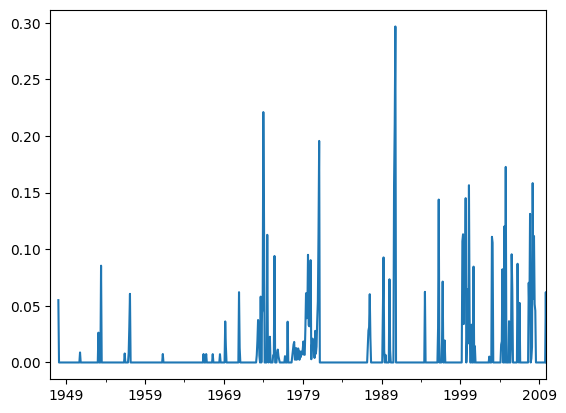

In [33]:
df.Oil.plot()

### в)

In [37]:
df_model = df.dropna()
df_model

,IP,Oil,ip_growth
1948-01-01,14.2538,0.055046,0.564246
1948-02-01,14.2806,0.000000,0.187844
1948-03-01,14.1201,0.000000,-1.130266
1948-04-01,14.1468,0.000000,0.188914
1948-05-01,14.3875,0.000000,1.687132
...,...,...,...
2009-08-01,87.7569,0.000000,1.223657
2009-09-01,88.3967,0.000000,0.726415
2009-10-01,88.6350,0.000000,0.269217
2009-11-01,89.1049,0.062096,0.528751


In [54]:
model = ARDL(endog=df_model.ip_growth, lags=0, exog=df_model[['Oil']], order=18, trend='c', causal=False).fit()
print(model.summary())
print(model.diagnostic_summary())

                              ARDL Model Results                              
Dep. Variable:              ip_growth   No. Observations:                  744
Model:                    ARDL(0, 18)   Log Likelihood               -1007.055
Method:               Conditional MLE   S.D. of innovations              0.937
Date:                Tue, 12 Dec 2023   AIC                           2056.109
Time:                        23:42:07   BIC                           2152.962
Sample:                    07-01-1949   HQIC                          2093.443
                         - 12-01-2009                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4275      0.045      9.587      0.000       0.340       0.515
Oil.L0         0.1553      1.351      0.115      0.909      -2.497       2.808
Oil.L1        -0.9760      1.438     -0.679      0.4

c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [75]:
model_robust = ARDL(endog=df_model.ip_growth, lags=0, exog=df_model[['Oil']], order=18, trend='c', causal=False).fit(cov_type='HAC', cov_kwds={'maxlags':18})
print(model_robust.summary())

                              ARDL Model Results                              
Dep. Variable:              ip_growth   No. Observations:                  744
Model:                    ARDL(0, 18)   Log Likelihood               -1007.055
Method:               Conditional MLE   S.D. of innovations              0.937
Date:                Tue, 12 Dec 2023   AIC                           2056.109
Time:                        23:47:27   BIC                           2152.962
Sample:                    07-01-1949   HQIC                          2093.443
                         - 12-01-2009                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4275      0.063      6.804      0.000       0.304       0.551
Oil.L0         0.1553      0.808      0.192      0.848      -1.432       1.742
Oil.L1        -0.9760      0.935     -1.044      0.2

c:\Users\Ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [83]:
str_rest = ' + '.join([f'Oil.L{i}' for i in range(19)]) + ' = 0'
str_rest

'Oil.L0 + Oil.L1 + Oil.L2 + Oil.L3 + Oil.L4 + Oil.L5 + Oil.L6 + Oil.L7 + Oil.L8 + Oil.L9 + Oil.L10 + Oil.L11 + Oil.L12 + Oil.L13 + Oil.L14 + Oil.L15 + Oil.L16 + Oil.L17 + Oil.L18 = 0'

In [119]:
print(model.f_test(str_rest))
print(model_robust.f_test(str_rest))

<F test: F=38.41299882128398, p=9.607882396429733e-10, df_denom=724, df_num=1>
<F test: F=17.04674711633618, p=4.071961184577043e-05, df_denom=724, df_num=1>


### д)

In [157]:
cum = model_robust.params[1:].cumsum()
cum

Oil.L0      0.155317
Oil.L1     -0.820687
Oil.L2     -2.223735
Oil.L3     -3.055282
Oil.L4     -3.461720
Oil.L5     -3.881911
Oil.L6     -6.436984
Oil.L7     -6.665579
Oil.L8     -5.785604
Oil.L9     -7.424841
Oil.L10   -11.348234
Oil.L11   -13.955644
Oil.L12   -14.180385
Oil.L13   -15.735068
Oil.L14   -17.218222
Oil.L15   -18.696996
Oil.L16   -18.797225
Oil.L17   -18.299148
Oil.L18   -18.289541
dtype: float64

In [158]:
#cum.index = cum.index.str[5:]
stds = np.sqrt(np.diag(model_robust.cov_params().iloc[1:, 1:].cumsum(axis=0).cumsum(axis=1)))
stds = pd.Series(stds, index=cum.index)
stds

Oil.L0     0.808275
Oil.L1     1.127470
Oil.L2     1.355671
Oil.L3     1.947119
Oil.L4     2.173428
Oil.L5     2.501294
Oil.L6     3.277913
Oil.L7     3.172333
Oil.L8     2.891190
Oil.L9     3.207009
Oil.L10    3.981094
Oil.L11    3.982955
Oil.L12    4.507208
Oil.L13    4.745075
Oil.L14    4.938257
Oil.L15    4.861970
Oil.L16    4.656923
Oil.L17    4.390003
Oil.L18    4.429779
dtype: float64

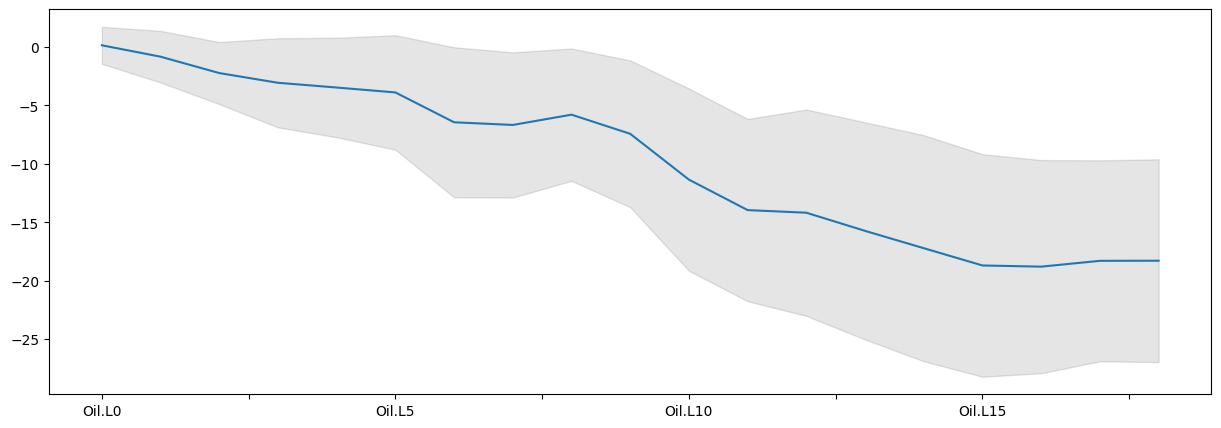

In [159]:
fig, ax = plt.subplots(figsize=(15, 5))
cum.plot(ax=ax)
ax.fill_between(stds.index, cum-1.96*stds, cum+1.96*stds, color='k', alpha=0.1)
plt.show();

# Задача 3

In [165]:
advert = pd.read_excel(r'advert.xlsx')
advert = pd.read_csv(r'advert.csv', sep=';', decimal=',')
advert

,x,y
0,4,27.0
1,3,25.7
2,0,24.3
3,5,23.2
4,3,27.6
...,...,...
115,1,25.3
116,8,22.5
117,8,25.7
118,0,29.3


In [168]:
adf_test(advert.x)

Results of Dickey-Fuller Test:
Test Statistic                -1.192212e+01
p-value                        5.003836e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64


In [169]:
adf_test(advert.y)

Results of Dickey-Fuller Test:
Test Statistic                -6.497256e+00
p-value                        1.185806e-08
#Lags Used                     0.000000e+00
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64


### а)

In [189]:
model_advert_y = ARDL(endog=advert.y, lags=3, exog=advert[['x']], order=3, causal=True, trend='c').fit()
print(model_advert_y.summary())

                              ARDL Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARDL(3, 3)   Log Likelihood                -179.698
Method:               Conditional MLE   S.D. of innovations              1.124
Date:                Wed, 13 Dec 2023   AIC                            375.396
Time:                        00:44:12   BIC                            397.493
Sample:                             3   HQIC                           384.367
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6475      1.687      6.905      0.000       8.305      14.990
y.L1           0.4887      0.094      5.181      0.000       0.302       0.676
y.L2          -0.1037      0.105     -0.987      0.3

In [190]:
print(model_advert_y.wald_test('x.L1 + x.L2 + x.L3 = 0', scalar=True, use_f=True)) #аргумент только ради того, чтобы убрать warning

<F test: F=55.47800109052987, p=2.2702259538544353e-11, df_denom=110, df_num=1>


In [192]:
model_advert_x = ARDL(endog=advert.x, lags=3, exog=advert[['y']], order=3, causal=True, trend='c').fit()
print(model_advert_x.wald_test('y.L1 + y.L2 + y.L3 = 0', scalar=True)) #аргумент только ради того, чтобы убрать warning

<F test: F=0.6397131347825364, p=0.42553855363237303, df_denom=110, df_num=1>


Вывод: x является причиной по Грейнджеру для y (p-value теста Вальда для причинности x на y > 0.05)

### б)

In [232]:
model_advert = ARDL(endog=advert.y, lags=0, exog=advert[['x']], order=2, causal=False).fit()
print(model_advert.summary())

                              ARDL Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARDL(0, 2)   Log Likelihood                -213.791
Method:               Conditional MLE   S.D. of innovations              1.437
Date:                Wed, 13 Dec 2023   AIC                            437.582
Time:                        01:00:46   BIC                            451.520
Sample:                             2   HQIC                           443.242
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6889      0.387     55.991      0.000      20.922      22.456
x.L0          -0.0110      0.046     -0.237      0.813      -0.102       0.081
x.L1           0.8305      0.047     17.842      0.0

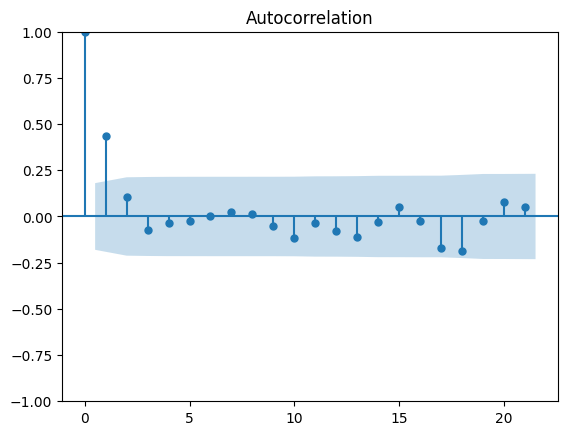

In [234]:
plot_acf(model_advert.resid);

In [235]:
durbin_watson(model_advert.resid)

1.1167119273319122

Статистика между -2 и 2 => есть автокорреляция в остатках

In [236]:
len(model_advert.resid)

118

In [239]:
len(model_advert.model.exog)

120

In [272]:
from statsmodels.tsa.ardl import ARDLResults
model_advert_holder = ARDLResults(model=ARDL, params = model_advert.params, cov_params = model_advert.cov_params)

AttributeError: type object 'ARDL' has no attribute 'data'

In [273]:
model_advert_holder.resid = model_advert.resid
model_advert_holder.model.exog = model_advert.model.exog[2:]

In [274]:
acorr_breusch_godfrey(model_advert_holder)

(26.228425333010183,
 0.003444813722553963,
 3.029492623819083,
 0.0020746748323962135)

In [278]:
acorr_ljungbox(model_advert.resid, lags=10, model_df=2)

,lb_stat,lb_pvalue
1,23.087900,NaN
2,24.429473,NaN
3,25.103190,5.434288e-07
4,25.241326,3.303054e-06
5,25.323853,1.321092e-05
6,25.323936,4.330025e-05
7,25.394905,1.168795e-04
8,25.420478,2.853499e-04
9,25.736191,5.613498e-04
10,27.435548,5.943794e-04


In [286]:
model_advert_HAC = ARDL(endog=advert.y, lags=0, exog=advert[['x']], order=2, causal=False).fit(cov_type='HAC', cov_kwds={'maxlags':3})
print(model_advert_HAC.summary())

                              ARDL Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARDL(0, 2)   Log Likelihood                -213.791
Method:               Conditional MLE   S.D. of innovations              1.437
Date:                Wed, 13 Dec 2023   AIC                            437.582
Time:                        01:38:04   BIC                            451.520
Sample:                             2   HQIC                           443.242
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6889      0.357     60.785      0.000      20.982      22.396
x.L0          -0.0110      0.044     -0.249      0.804      -0.098       0.076
x.L1           0.8305      0.044     19.044      0.0

### в)

In [302]:
model_advert_best = ARDL(endog=advert.y, lags=0, exog=advert[['x']], order=[1, 2], causal=False).fit()
print(model_advert_best.summary())

                              ARDL Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARDL(0, 2)   Log Likelihood                -213.821
Method:               Conditional MLE   S.D. of innovations              1.437
Date:                Wed, 13 Dec 2023   AIC                            435.641
Time:                        01:41:19   BIC                            446.791
Sample:                             2   HQIC                           440.169
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6406      0.328     65.939      0.000      20.991      22.291
x.L1           0.8316      0.046     18.026      0.000       0.740       0.923
x.L2           0.4138      0.047      8.886      0.0

In [297]:
durbin_watson(model_advert_best.resid)

1.1125490047257787

### г)

In [301]:
model_advert_ar = ARDL(endog=advert.y, lags=1, exog=advert[['x']], order=1, causal=False).fit()
print(model_advert_ar.summary())

                              ARDL Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARDL(1, 1)   Log Likelihood                -183.629
Method:               Conditional MLE   S.D. of innovations              1.132
Date:                Wed, 13 Dec 2023   AIC                            377.258
Time:                        01:41:16   BIC                            391.154
Sample:                             1   HQIC                           382.901
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9294      0.990     10.035      0.000       7.969      11.889
y.L1           0.5026      0.035     14.159      0.000       0.432       0.573
x.L0          -0.0077      0.036     -0.215      0.8